# Power Spectral Analysis with X-ray data

In this tutorial, we will show you how to 

1. make a light curve out photon event data
2. make a light curve out of binned data
3. make a power spectrum out of a light curve
4. fit that power spectrum with various models

Note that this tutorial specifically covers data that consists of 
photons, that is, is well-described by Poisson statistics. 
There will be another tutorial describing data with other statistics
(e.g. optical). 

## Imports

First, we'll do the necessary imports.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import seaborn as sns
except ImportError:
    print("No seaborn. Plots will look less pretty!")

import numpy as np
import scipy.stats

from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum
from stingray import PSDPosterior, PSDRegression
from stingray import Const, PowerLaw, PowerLawConst, Lorentzian

## set the random seed for numpy.random
np.random.seed(20151231)

## Making a Light Curve

First, we need to load some time series data and make a light curve out of it. In general, X-ray data comes in two flavours: either (1) time-tagged event data or (2) binned data. In the first case, the instrument records raw photon arrival times at the detector and saves a list of these arrival times. The photons generally obey the statistical description of an inhomogeneous Poisson process. Note that any data processing (e.g. removal of house-keeping data and barycentering of the photons) needs to be applied in advance; at this point, this package does not support instrument-specific data processing. 
In this case, the data is a single column of photon arrival times.

In the second case, either the instrument's time resolution is too big to resolve individual photons, or the data has been binned in the data processing. Again, the data follows Poisson statistics, the data will be in two columns: time stamps and the counts in a bin. 

### A light curve from photon event lists

Let's make some photon arrival time data. We'll make a flat light curve (constant mean count rate), which is really easy to do: 

In [2]:
## define a length for the light curve
tseg = 1000.0
## start time
tstart = 0
## end time
tend = tstart + tseg

## pick the number of Poisson counts in the entire segment
total_counts = np.random.poisson(100000.0)
print("Total counts: " + str(total_counts))

## distribute photons randomly throughough the time segment
photon_arrivals = np.random.uniform(tstart,tend, size=total_counts)

## sort photons in time
photon_arrivals = np.sort(photon_arrivals)


Total counts: 99229


Now we can make a light curve. We'll do this by calling the `make_lightcurve` method of the `Lightcurve` class. We will also need to define a time resolution `dt` of the resulting light curve. If the total length of the light curve is not an integer multiple of `dt`, then the last bit of the light curve will be cut off. 

By default, `make_lightcurve` will make a light curve that starts at the arrival time of the first photon and ends at the arrival time of the last photon. In practice, this is random true: the instrument could have started observing before and finished observing after the arrival of the first and last photon, respectively. Thus, the method allows for the definition of a keyword `tstart` and a keyword `tseg` describing the start time and the total length of the light curve.

**Note**: Be careful with photon event lists from instruments with a relatively coarse time resolution. Some instruments (e.g. XMM-Newton) produce event lists from light curves with a low time resolution (of seconds or so). In these event lists, either all photon arrival times are set to the start time of the time bin it has been recorded in, or the photon arrival times have been artificially randomized within the bin. In the first case, artifacts in a Fourier-based timing analysis are likely at the beat frequencies between the time resolution chosen and the time resolution of the original data, though randomization effectively takes care of that problem. Randomized photon arrival times are easier to work with, though their time resolution remains that of the original light curve returned by the instrument. Making light curves with a shorter resolution is to be avoided in order to avoid edge effects due to the bin edges.

In [3]:
dt = 5.0
lc = Lightcurve.make_lightcurve(photon_arrivals, dt=dt, tstart=tstart, tseg=tseg)

tseg: 1000.0
timebin:  200


The result is an instance of class `Lightcurve`:

In [7]:
lc.__dict__.keys()

['countrate', 'ncounts', 'tstart', 'time', 'counts', 'tseg', 'dt']

The attribute `time` describes the time stamps of the light curve; the keywords `counts` and `countrate` the counts per bin and the counts per second, respectively. `ncounts` contains the total number of counts, `tseg` and `dt` expose the input keywords.

Let's have a look what our light curve looks like in practice:

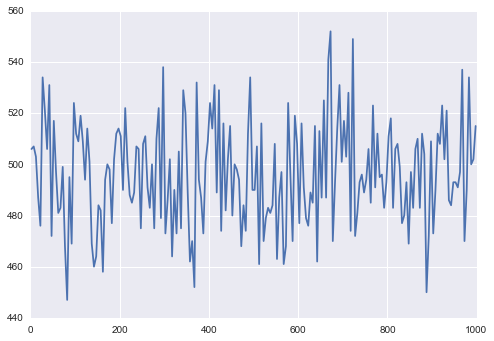

In [8]:
plt.plot(lc.time, lc.counts)

We can also plot the count rate (counts/second) rather than counts/bin:

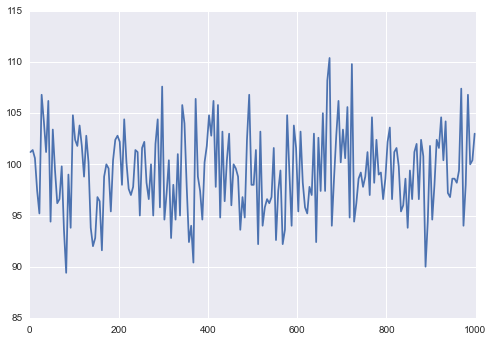

In [11]:
plt.plot(lc.time, lc.countrate)

### A light curve from counts or count rates

Let's also make a light curve from count data.
This is pretty simple. Instead of calling `make_lightcurve`, we can instantiate the `Lightcurve` object directly.

First, let's make some data:

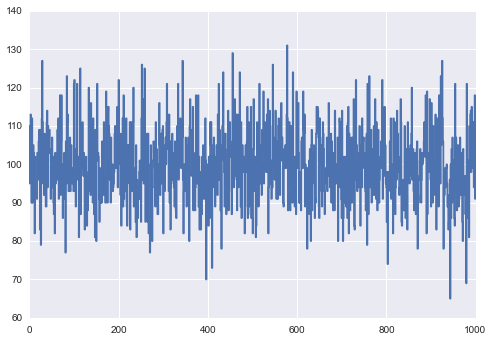

In [22]:
times = np.linspace(tstart, tstart+tseg, 1000)
counts = np.random.poisson(100, size=times.shape[0])

plt.plot(times, counts, linestyle="steps-mid")

Now we can make the light curve:

In [12]:
lc = Lightcurve(times, counts)

And that's all! [ADD NEW PART ABOUT COUNT RATE DATA AS SOON AS THE PULL REQUEST IS MERGED!]

### Rebinning light curves

Sometimes, you might want to re-bin a light curve to a different time resolution.
This is possible, too, by calling `rebin_lightcurve` on the `Lightcurve` object. This will return a new instance of class `Lightcurve`.

The keyword `method` determines whether the counts in the new bins should be summed (`"sum"`) or averaged (`"average"` or `"mean"`).

In [14]:
dt_new = 10.0
lc_bin = lc.rebin_lightcurve(dt_new, method="sum")

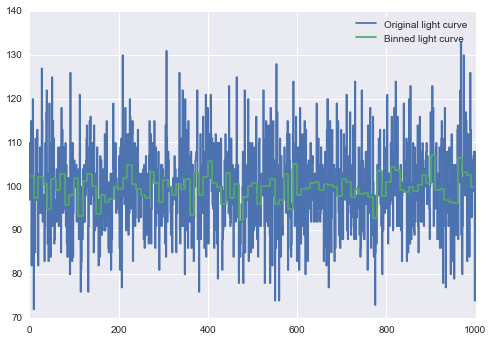

In [23]:
plt.plot(lc.time, lc.countrate, linestyle="steps-mid")
plt.plot(lc_bin.time, lc_bin.countrate, linestyle="steps-mid")
plt.legend(["Original light curve", "Binned light curve"])

## Making Power Spectra

Light curves only get you so far. Our next task is to make power spectra. 
This is possible by instantiating class `Powerspectrum`, which takes a `Lightcurve` object as input.

It is possible to make power spectra in the most common normalizations: the standard Leahy normalization (REF) and the RMS normalization (REF). In the first case, random Poisson noise will default to powers that are distributed following a $\chi^2_2$ distribution around a value of 2. In the latter case, the power spectrum will be normalized such that the square root of the sum of all powers equals that standard deviation of the light curve [CHECK WHETHER THIS IS TRUE!]. For details on power spectral statistics, please see the accompanying notebook in the same folder called `PowerSpectralStatistics`. 

In [38]:
ps = Powerspectrum(lc, norm="rms")

In [20]:
ps.__dict__.keys()

['ps', 'df', 'm', 'n', 'freq', 'nphots', 'unnorm_powers', 'norm']

The power spectrum itself is in the keyword `freq` containing the list of frequencies and the keyword `ps` containing the powers. `df` exposes the frequency resolution, `n` is twice the number of frequencies, `nphots` the total number of photons (useful in the normalization). `norm` exposes the normalization used, `unnorm_powers` are the raw squared Fourier amplitudes without normalization. Finally, `m` is a useful keyword defining the number of averaged powers in each bin. In this simple case above, this number is 1, however, this may be different when actually defining averaged power spectra or re-binned power spectra. Its importance lies when doing any sort of further analysis on these powers, since averaging powers changes the statistical distribution to be used in describing them.

Let's see what this spectrum looks like:

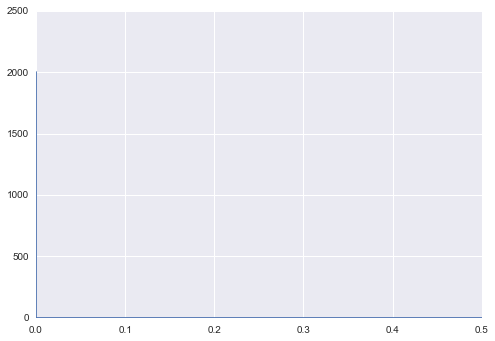

In [24]:
plt.plot(ps.freq, ps.ps, linestyle="steps-mid")

This does not look particularly useful. The main reason is that both frequencies and powers extend over several orders of magnitude:

In [28]:
print("The smallest frequency is %.4f"%np.min(ps.freq))
print("The largest frequency is %.4f"%np.max(ps.freq))

print("The smallest power is %.4f"%np.min(ps.ps))
print("The largest power is %.4f"%np.max(ps.ps))


The smallest frequency is 0.0005
The largest frequency is 0.5000
The smallest power is 0.0001
The largest power is 2002.0020


Instead, let's plot on a logarithmic scale in both axes:

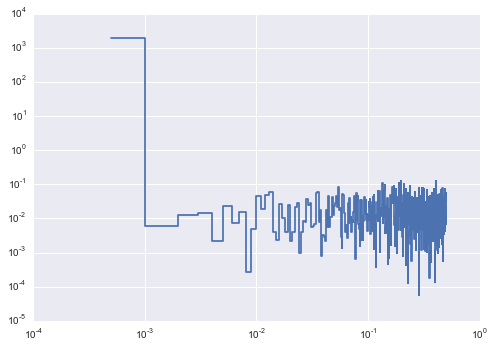

In [29]:
plt.loglog(ps.freq, ps.ps, linestyle="steps-mid")

This looks more reasonable. We should also note that the zeroth frequency is related to the numer of photons and not useful for scientific analysis, thus it is generally better to leave it out (some of the code later in this tutorial will do this automatically).

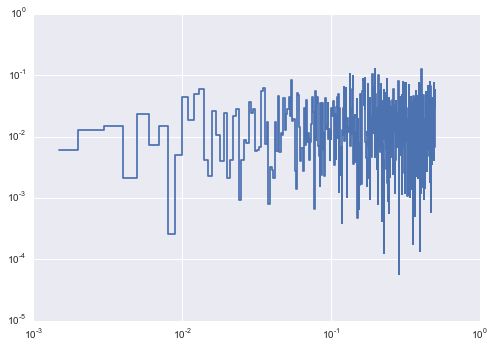

In [30]:
plt.loglog(ps.freq[1:], ps.ps[1:], linestyle="steps-mid")

We can do several things with this power spectrum.
For example, we can easily compute the fractional rms amplitude between two 
frequencies:

In [35]:
f_min, f_max = 0.01, 0.1
rms, rms_error = ps.compute_rms(f_min, f_max)

print("The fractional rms amplitude between %f and %f "%(f_min, f_max) + 
      "is %f +/- %f"%(rms, rms_error))

The fractional rms amplitude between 0.010000 and 0.100000 is 0.041412 +/- 0.082824


### Rebinning power spectra

Much like the light curve, we can also rebin the power spectrum. Similarly, the `rebin` method also exposes a keyword `method` describing whether the powers should be summed or averaged. It returns another object of type `Powerspectrum`.

In [39]:
df_new = 10*ps.df
ps_new = ps.rebin(df_new, method="mean")

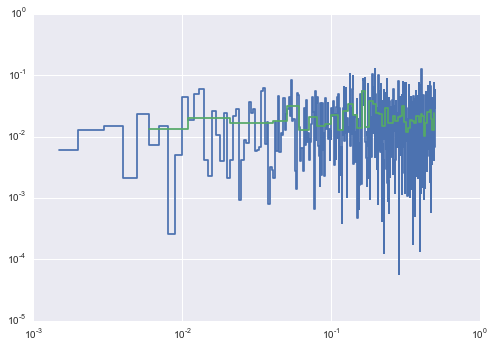

In [40]:
plt.loglog(ps.freq[1:], ps.ps[1:], linestyle="steps-mid")
plt.loglog(ps_new.freq[1:], ps_new.ps[1:], linestyle="steps-mid")

The resulting binned power spectrum has a lower frequency resolution and lacks the lowest few powers (due to its smaller frequency resolution), but binning the powers results in a smaller standard deviation.

Unlike the light curve, the fact that the power spectrum extends over several orders of magnitude in both frequency and powers can make it useful to compute a logarithmically binned power spectrum. In this case, the width of each bin depends on the width of the previous bin and will be larger than that by a constant factor `f`:

In [44]:
binfreq, binps, binsamples = ps.rebin_log(f=0.01)

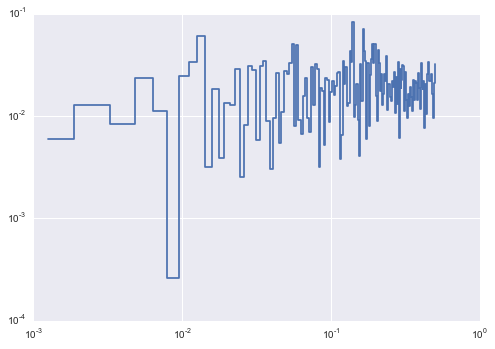

In [46]:
plt.loglog(binfreq, binps, linestyle="steps-mid")

As can be seen, the standard deviation becomes smaller at higher frequencies. This is due to the larger number of powers averaged at higher frequencies (because the bins are wider) compared to lower frequencies.

In [48]:
print(binsamples)

[1 1 1 2 1 2 1 2 2 1 2 2 1 2 2 1 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 2 2 3 2 2 2
 2 2 2 3 2 2 2 3 2 2 3 2 3 2 2 3 2 3 3 2 3 2 3 3 2 3 3 3 3 3 2 3 3 3 3 3 3
 3 4 3 3 3 3 4 3 3 4 3 4 3 4 3 4 4 3 4 4 3 4 4 4 4 4 4 4 4 4 4 5 4 4 5 4 4
 5 4 5 5 4 5 5 5 4 5 5 5 5 5 6 5 5 5 6 5 6 5 6 5 6 6 6 5 6 6 6 6 7 6 6 6 7]
